In [1]:
# Basic libraries

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.utils as vutils
import torchvision.datasets as vdatasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from time import time



In [2]:
# do we have a gpu?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device.type)

Device: cpu


In [3]:
# do we want to set a random seed, for reproducibility?

randomSeed = None

if randomSeed:
    torch.manual_seed(randomSeed)
    rng = np.random.default_rng(randomSeed)
    random.seed(randomSeed)
    if device.type == 'cuda':
        torch.cuda.manual_seed_all(randomSeed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
else:
    rng = np.random.default_rng()

print("Random Seed:", randomSeed)

Random Seed: None


In [4]:
# Some global parameters

image_size = 28      # 28x28 pixels

image_channels = 1   # grayscale

ngpu = 1 if device.type == 'cuda' else 0

num_workers = 0   # for DataLoader, since we aren't actually loading files
pin = (device.type == 'cuda')    # for DataLoader

In [5]:
# --------------------------------
# LOAD DATA
# --------------------------------

from pathlib import Path
import gzip
import pickle
import requests

# loading it old school . . . 

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)
    


with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

# Set up train vs test sets

x_train = torch.Tensor(x_train)
x_valid = torch.Tensor(x_valid)

print("Train:", len(x_train),"\tTest:", len(x_valid))

Train: 50000 	Test: 10000


In [6]:
# helpers for showing images and saving them

import datetime

def get_figure_filename_now(filestem):
    """Simple timestamped figure filename"""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    return f"{filestem}_{timestamp}.jpg"
    
def show_examples(images, nrow, width=10, title = "", filestem=None):
    """Show a grid of images using matplotlib."""
    n_images = images.size(0)
    n_rows = np.ceil(n_images / nrow)
    height = width*n_rows / nrow
    grid = vutils.make_grid(images, nrow=nrow, padding=2, normalize=False)

    plt.figure(figsize=(width, height))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    if filestem:
        plt.savefig(get_figure_filename_now(filestem))
    plt.show()
    plt.close()
 

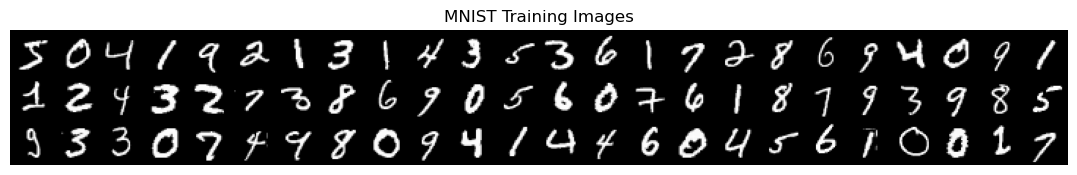

In [7]:
# SHOW EXAMPLES OF TRAINING IMAGES

train_examples = x_train[:24*3].view(24*3,1,image_size,image_size)

show_examples(train_examples, nrow=24, width=14, title="MNIST Training Images")

In [8]:
# Find the distribution of distances between image vectors in the dataset
# We will use these empirical distances to fit the IMQ kernel to the sum of Gaussians

num_dist = 10000

total_count = len(x_train)
indices = np.arange(total_count, dtype=int)
rng.shuffle(indices)

select = indices[:num_dist*2]

batch1 = x_train[select[:num_dist]]
batch2 = x_train[select[num_dist:]]

sum_sq = ((batch1 - batch2)**2).sum(dim=1)
distances = np.sort(torch.sqrt(sum_sq))
print("Median distance:",distances[num_dist//2])

Median distance: 10.182447


In [9]:
# Find best-fit parameters for inverse multiquadric kernel

from scipy.optimize import curve_fit

def gaussian(x, mu, sigma):
    """Returns the Gaussian function value at x with mean mu and standard deviation sigma."""
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def sum_of_gaussians(x, sigmas):
    """Returns the sum of Gaussian functions at x for a list of standard deviations (sigmas)."""
    return sum(gaussian(x, 0, sigma) for sigma in sigmas)

def IMQ_func(x, alpha, scale):
    """Inverse multiquadric, with alpha and scale parameters"""
    return np.power((1+(x**2/(2*alpha*scale**2))),-(alpha))

x = distances

# List of sigmas
sig_sq = [2,5,10,20,40,80]   # note in the original GMMN code these are sigma-squared
sigmas = np.sqrt(sig_sq)


# Calculate the mixture of Gaussians
y = sum_of_gaussians(x, sigmas) / len(sigmas)

# Find the best fit
popt, pcov = curve_fit(IMQ_func, x, y, bounds=(0,np.inf))

best_alpha = popt[0]
best_scale = popt[1]

print("Alpha:",best_alpha," Scale:",best_scale)

Alpha: 1.1963137888049793  Scale: 3.2813178088061052


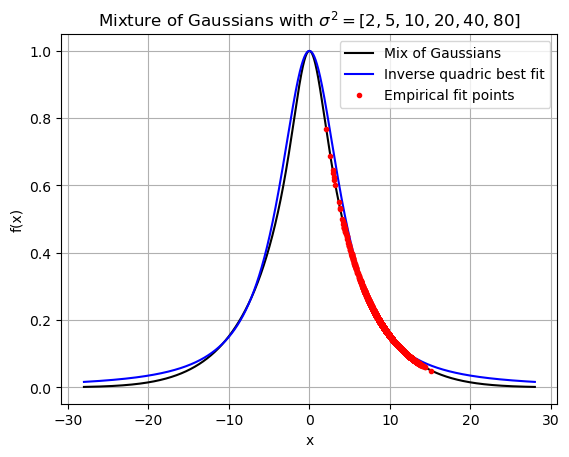

In [10]:
span = np.sqrt(784)   
# the maximum distance between vectors with components in [0,1] in the 784-dim image space

x_plot = np.linspace(-span, span, 10000)
y_plot = sum_of_gaussians(x_plot, sigmas) / len(sigmas)

y_fit = IMQ_func(x_plot, best_alpha, best_scale)

plt.plot(x_plot, y_plot, '-k', label='Mix of Gaussians')
plt.plot(x_plot, y_fit, '-b', label='Inverse quadric best fit')
plt.plot(x, y, '.r', label='Empirical fit points')
plt.title(f'Mixture of Gaussians with $\\sigma^2 = {sig_sq}$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# --------------------------------
# Generator Code (GMMN, Gaussian Moment Matching Network)
# Architecture and parameters from https://github.com/yujiali/gmmn
# --------------------------------

n_hidden = np.array([10, 64, 256, 256, 1024, image_size**2])
nz_GMMN = n_hidden[0]  # dimension of the latent space

class Hid_ReLU(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        self.main = nn.Sequential(
                        nn.Linear(in_dim, out_dim),
                        nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.main(input)    

class GMMN(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            *[Hid_ReLU(n_hidden[i], n_hidden[i+1]) for i in range(len(n_hidden)-2)],
            nn.Linear(n_hidden[-2], n_hidden[-1]),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

model=GMMN()
print(model)

GMMN(
  (main): Sequential(
    (0): Hid_ReLU(
      (main): Sequential(
        (0): Linear(in_features=10, out_features=64, bias=True)
        (1): ReLU(inplace=True)
      )
    )
    (1): Hid_ReLU(
      (main): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
    )
    (2): Hid_ReLU(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
    )
    (3): Hid_ReLU(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): ReLU(inplace=True)
      )
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [12]:
def noisemaker(batch_size, device=device):
    """Create an appropriate randomized latent vector for generation"""
    z = torch.rand(batch_size, nz_GMMN, device=device)*2 - 1
    return z
    

In [13]:
def weights_init(m):
    """Initialize the model"""
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=1 / np.sqrt(m.in_features))
        nn.init.zeros_(m.bias)


In [14]:
def compute_Gram(x, y, kind='QPM'):
    """Compute the Gram matrix for the combined vectors in x and y"""
    
    dim = x.size(0)     # number of samples; assume x and y have same #
    x = x.view(dim, -1)
    y = y.view(dim, -1)

    alpha = torch.tensor(best_alpha, dtype=x.dtype, device=x.device)  # choose best-fit parameters defined above
    scale = torch.tensor(best_scale, dtype=x.dtype, device=x.device)
    
    V = torch.cat((x,y),0)
    C = V @ V.T

    D = torch.diagonal(C)
    distsq = D[:,None] + D[None,:] - 2*C  # pairwise distance-squared matrix

    if kind=='QPM':
        gram = torch.pow((1+(distsq/(2*alpha*scale**2))),-(alpha/2))  # square root of inverse-multiquadric kernel
    else:
        gram = torch.pow((1+(distsq/(2*alpha*scale**2))),-(alpha))   # IMQ kernel

    return gram
    

In [15]:
def calc_loss(gram, kind='QPM', permute=False):
    """Calculate the loss, using either QPM or MMD, for the given Gram matrix."""

    dim = gram.size(0)//2   # half the dimension of the Gram matrix = number of samples (x or y)

    wei=torch.ones(2,dim,device=gram.device)/dim    # weights (c_i in the text)
    wei[1,:] *= -1
    wei = wei.view(-1)
    
    if permute:
        perm_ind = torch.randperm(dim*2, device=gram.device)
        wei = wei[perm_ind]

    eps = 1e-4  # regularization
    reg = eps*torch.eye(dim*2, dtype=gram.dtype, device=gram.device)

    if kind=='QPM':
        try:
            H = torch.linalg.cholesky(gram+reg)
            M = H.T @ (wei[:,None]*H)    # same as multiplying diag(wei) @ H
            L = torch.linalg.eigvalsh(M)
        except torch.linalg.LinAlgError:
            dist = wei[:,None]*gram
            L = torch.linalg.eigvals(dist).real
            print("Cholesky failed; using non-Hermitian eigensolver instead")
        loss = L.abs().sum()/2*np.sqrt(2)   # multiply by sqrt(2) for isometry
    else:
        P = torch.dot(wei, gram @ wei)
        loss = torch.sqrt(torch.clamp(P, min=0.0))
        H = None

    return loss
    

In [16]:
# Test to make sure that the distance between point masses is the same in both metrics

test_num = 10
data_size = len(x_train)

for i in range(test_num):
    x1 = x_train[rng.integers(0,data_size)].view(1,-1).to(device)
    x2 = x_train[rng.integers(0,data_size)].view(1,-1).to(device)
    
    QPM_dist = calc_loss(compute_Gram(x1, x2, 'QPM'),'QPM').item()
    MMD_dist = calc_loss(compute_Gram(x1, x2, 'MMD'),'MMD').item()
    
    print(f'QPM: {QPM_dist:.5f} \tMMD:{MMD_dist:.5f} \tDiscrepancy: {np.abs(QPM_dist-MMD_dist):.5f}')

# May observe small discrepancies ca. 10^-4 due to regularization! 

QPM: 1.33068 	MMD:1.33053 	Discrepancy: 0.00015
QPM: 1.33924 	MMD:1.33909 	Discrepancy: 0.00015
QPM: 1.27471 	MMD:1.27456 	Discrepancy: 0.00016
QPM: 1.32188 	MMD:1.32173 	Discrepancy: 0.00015
QPM: 1.30207 	MMD:1.30192 	Discrepancy: 0.00015
QPM: 1.29579 	MMD:1.29563 	Discrepancy: 0.00015
QPM: 1.27927 	MMD:1.27911 	Discrepancy: 0.00016
QPM: 1.32283 	MMD:1.32268 	Discrepancy: 0.00015
QPM: 1.30686 	MMD:1.30670 	Discrepancy: 0.00015
QPM: 1.31153 	MMD:1.31138 	Discrepancy: 0.00015


In [17]:
def perm_test(gram, kind='QPM', n_perm=100):
    """Permutation two-sample test, given Gram matrix, report p-value"""

    if n_perm >= 200:
        my_tqdm = tqdm   # show progress bar for 200 or more permutations
    else:
        my_tqdm = lambda x: x
    
    with torch.no_grad():
    
        baseline = calc_loss(gram, kind, permute=False).detach().cpu().numpy()
        perm_stats = np.zeros(n_perm)
        
        for i in my_tqdm(range(n_perm)):
            perm_dist = calc_loss(gram, kind, permute=True).detach().cpu().numpy()
            perm_stats[i] = perm_dist
            
        r = np.sum(perm_stats >= baseline)
        p_value = (r+1) / (n_perm+1)   # continuity corrected

    return p_value
    

In [18]:
# Set up the model and initialize it to prepare for training



n_batch = 1000

# prepare data loader
train_loader = torch.utils.data.DataLoader(x_train[:], batch_size=n_batch, 
                                           shuffle=True, num_workers=num_workers, pin_memory=pin)

model_QPM = GMMN().to(device)
model_QPM.apply(weights_init)

model_MMD = GMMN().to(device)
model_MMD.apply(weights_init)

learning_rate = 0.005

print(f'{sum(p.numel() for p in model_QPM.parameters())/1e6:.2f} M parameters')

optimizer_QPM = torch.optim.AdamW(model_QPM.parameters(), lr=learning_rate)
optimizer_MMD = torch.optim.AdamW(model_MMD.parameters(), lr=learning_rate)

1.15 M parameters


Training started with device: cpu


100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.48it/s]


Epoch: 10  	Total time: 3.4 minutes
QPM: 	Loss: 0.659043 	P ~ 0.01


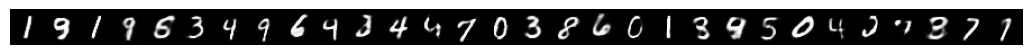

MMD: 	Loss: 0.081962 	P ~ 0.01


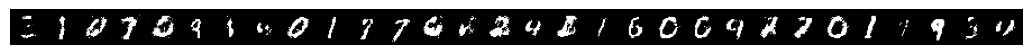

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.48it/s]


Epoch: 20  	Total time: 7.2 minutes
QPM: 	Loss: 0.648497 	P ~ 0.01


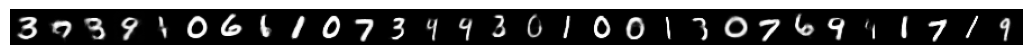

MMD: 	Loss: 0.057149 	P ~ 0.01


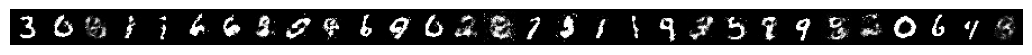

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.47it/s]


Epoch: 30  	Total time: 11.1 minutes
QPM: 	Loss: 0.641798 	P ~ 0.01


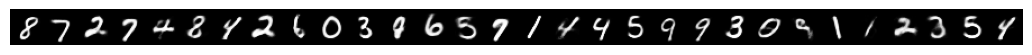

MMD: 	Loss: 0.050941 	P ~ 0.01


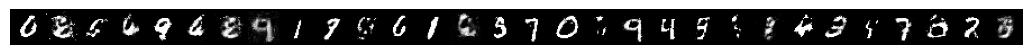

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.48it/s]


Epoch: 40  	Total time: 14.9 minutes
QPM: 	Loss: 0.639232 	P ~ 0.01


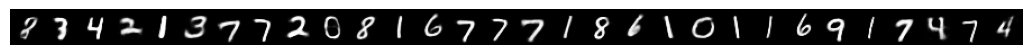

MMD: 	Loss: 0.050702 	P ~ 0.01


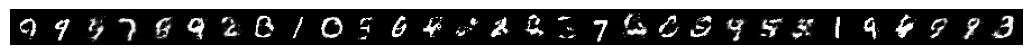

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.48it/s]


Epoch: 50  	Total time: 18.8 minutes
QPM: 	Loss: 0.637260 	P ~ 0.01


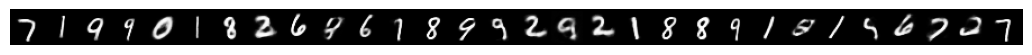

MMD: 	Loss: 0.048878 	P ~ 0.01


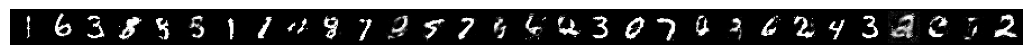

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.41it/s]


Epoch: 60  	Total time: 22.6 minutes
QPM: 	Loss: 0.636402 	P ~ 0.01


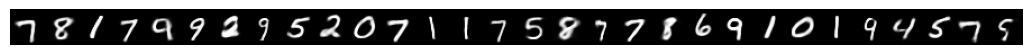

MMD: 	Loss: 0.048293 	P ~ 0.01


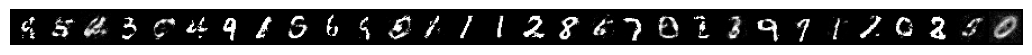

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.46it/s]


Epoch: 70  	Total time: 26.5 minutes
QPM: 	Loss: 0.636110 	P ~ 0.01


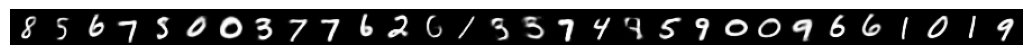

MMD: 	Loss: 0.047917 	P ~ 0.01


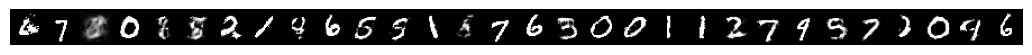

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.46it/s]


Epoch: 80  	Total time: 30.4 minutes
QPM: 	Loss: 0.635579 	P ~ 0.01


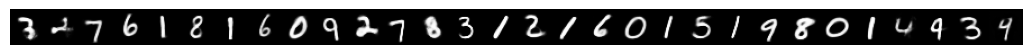

MMD: 	Loss: 0.047962 	P ~ 0.01


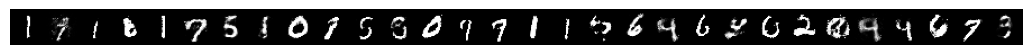

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.45it/s]


Epoch: 90  	Total time: 34.2 minutes
QPM: 	Loss: 0.634470 	P ~ 0.01


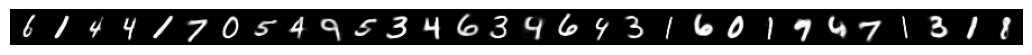

MMD: 	Loss: 0.047227 	P ~ 0.02


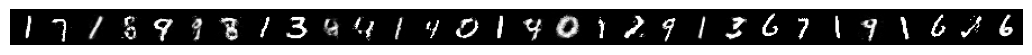

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.46it/s]


Epoch: 100  	Total time: 38.1 minutes
QPM: 	Loss: 0.634915 	P ~ 0.01


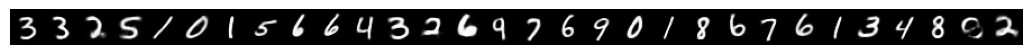

MMD: 	Loss: 0.046986 	P ~ 0.01


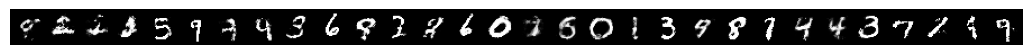

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.48it/s]


Epoch: 110  	Total time: 41.9 minutes
QPM: 	Loss: 0.633052 	P ~ 0.01


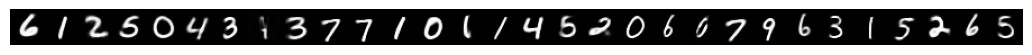

MMD: 	Loss: 0.046570 	P ~ 0.01


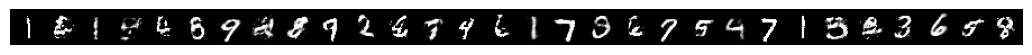

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.47it/s]


Epoch: 120  	Total time: 45.8 minutes
QPM: 	Loss: 0.632884 	P ~ 0.01


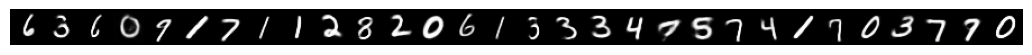

MMD: 	Loss: 0.046327 	P ~ 0.01


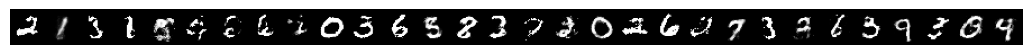

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.46it/s]


Epoch: 130  	Total time: 49.7 minutes
QPM: 	Loss: 0.633915 	P ~ 0.01


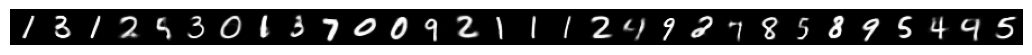

MMD: 	Loss: 0.046478 	P ~ 0.04


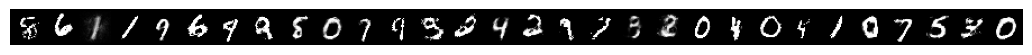

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.42it/s]


Epoch: 140  	Total time: 53.6 minutes
QPM: 	Loss: 0.633742 	P ~ 0.01


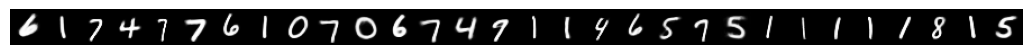

MMD: 	Loss: 0.045633 	P ~ 0.04


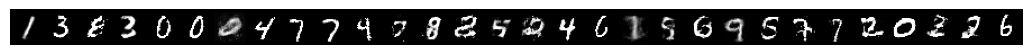

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.44it/s]


Epoch: 150  	Total time: 57.5 minutes
QPM: 	Loss: 0.632617 	P ~ 0.01


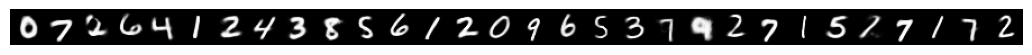

MMD: 	Loss: 0.046308 	P ~ 0.01


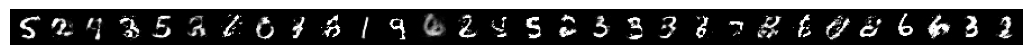

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.42it/s]


Epoch: 160  	Total time: 61.4 minutes
QPM: 	Loss: 0.633361 	P ~ 0.01


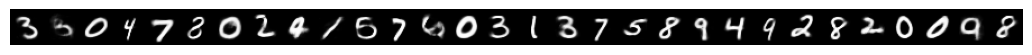

MMD: 	Loss: 0.046792 	P ~ 0.07


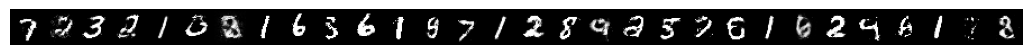

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.43it/s]


Epoch: 170  	Total time: 65.3 minutes
QPM: 	Loss: 0.632208 	P ~ 0.01


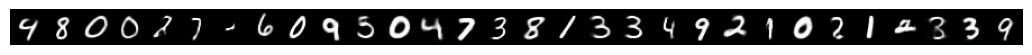

MMD: 	Loss: 0.045712 	P ~ 0.01


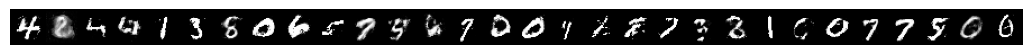

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.46it/s]


Epoch: 180  	Total time: 69.2 minutes
QPM: 	Loss: 0.631496 	P ~ 0.01


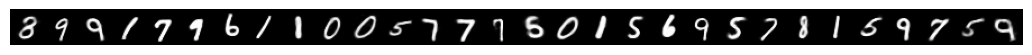

MMD: 	Loss: 0.045278 	P ~ 0.01


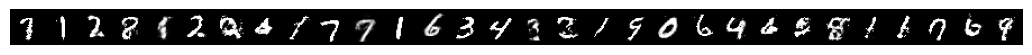

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.47it/s]


Epoch: 190  	Total time: 73.0 minutes
QPM: 	Loss: 0.632010 	P ~ 0.01


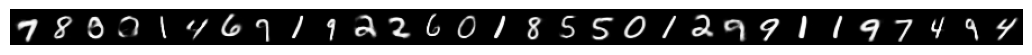

MMD: 	Loss: 0.045561 	P ~ 0.02


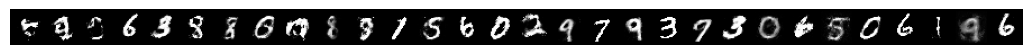

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.46it/s]


Epoch: 200  	Total time: 76.9 minutes
QPM: 	Loss: 0.631863 	P ~ 0.01


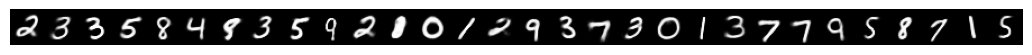

MMD: 	Loss: 0.044929 	P ~ 0.01


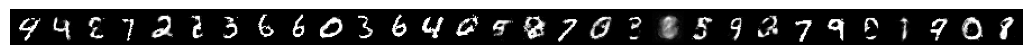

Finished training


In [19]:
# Training loop!

model_QPM.train()
model_MMD.train()

n_epochs = 200    # number of epochs to train the model
report_epoch = 10  # how often to show training statistics and examples

start_time = time()
print("Training started with device:", device.type)

for epoch in range(1, n_epochs+1):
    # monitor training loss
    running_loss_QPM = 0.0
    running_loss_MMD = 0.0
    
    ###################
    # train the model #
    ###################
    for batch in tqdm(train_loader):

        batch_size = batch.size(0)
        target = batch.to(device).view(batch_size, -1)

        noise_QPM = noisemaker(batch_size)
        output_QPM = model_QPM(noise_QPM).view(batch_size, -1)
            
        gram_QPM = compute_Gram(output_QPM, target, 'QPM')
        loss_QPM = calc_loss(gram_QPM, 'QPM')
        
        optimizer_QPM.zero_grad(set_to_none=True)
        loss_QPM.backward()
        optimizer_QPM.step()
        running_loss_QPM += loss_QPM.item()

        noise_MMD = noisemaker(batch_size)
        output_MMD = model_MMD(noise_MMD).view(batch_size, -1)
            
        gram_MMD = compute_Gram(output_MMD, target, 'MMD')
        loss_MMD = calc_loss(gram_MMD, 'MMD')

        optimizer_MMD.zero_grad(set_to_none=True)
        loss_MMD.backward()
        optimizer_MMD.step()
        running_loss_MMD += loss_MMD.item()

   
    # print avg training statistics and estimated p-values for most recent epoch
    if (epoch % report_epoch) == 0:
        display_imgs = 30
        total_minutes = (time()-start_time)/60
        print(f'Epoch: {epoch}  \tTotal time: {total_minutes:.1f} minutes')
        N_img = min(batch_size, display_imgs)
    
        avg_loss_QPM = running_loss_QPM/len(train_loader)
        with torch.no_grad():
            p_val_QPM = perm_test(gram_QPM, 'QPM', 100)
            print(f'QPM: \tLoss: {avg_loss_QPM:.6f} \tP ~ {p_val_QPM:.2f}')
            train_examples = output_QPM[:N_img].view(N_img,image_channels,image_size,image_size).cpu()
        show_examples(train_examples, nrow=display_imgs, width=14)
        
        avg_loss_MMD = running_loss_MMD/len(train_loader)
        with torch.no_grad():
            p_val_MMD = perm_test(gram_MMD, 'MMD', 100)
            print(f'MMD: \tLoss: {avg_loss_MMD:.6f} \tP ~ {p_val_MMD:.2f}')
            train_examples = output_MMD[:N_img].view(N_img,image_channels,image_size,image_size).cpu()
        show_examples(train_examples, nrow=display_imgs, width=14)

# done with training; rest of code uses evaluation mode
model_QPM.eval()
model_MMD.eval()

print("Finished training")

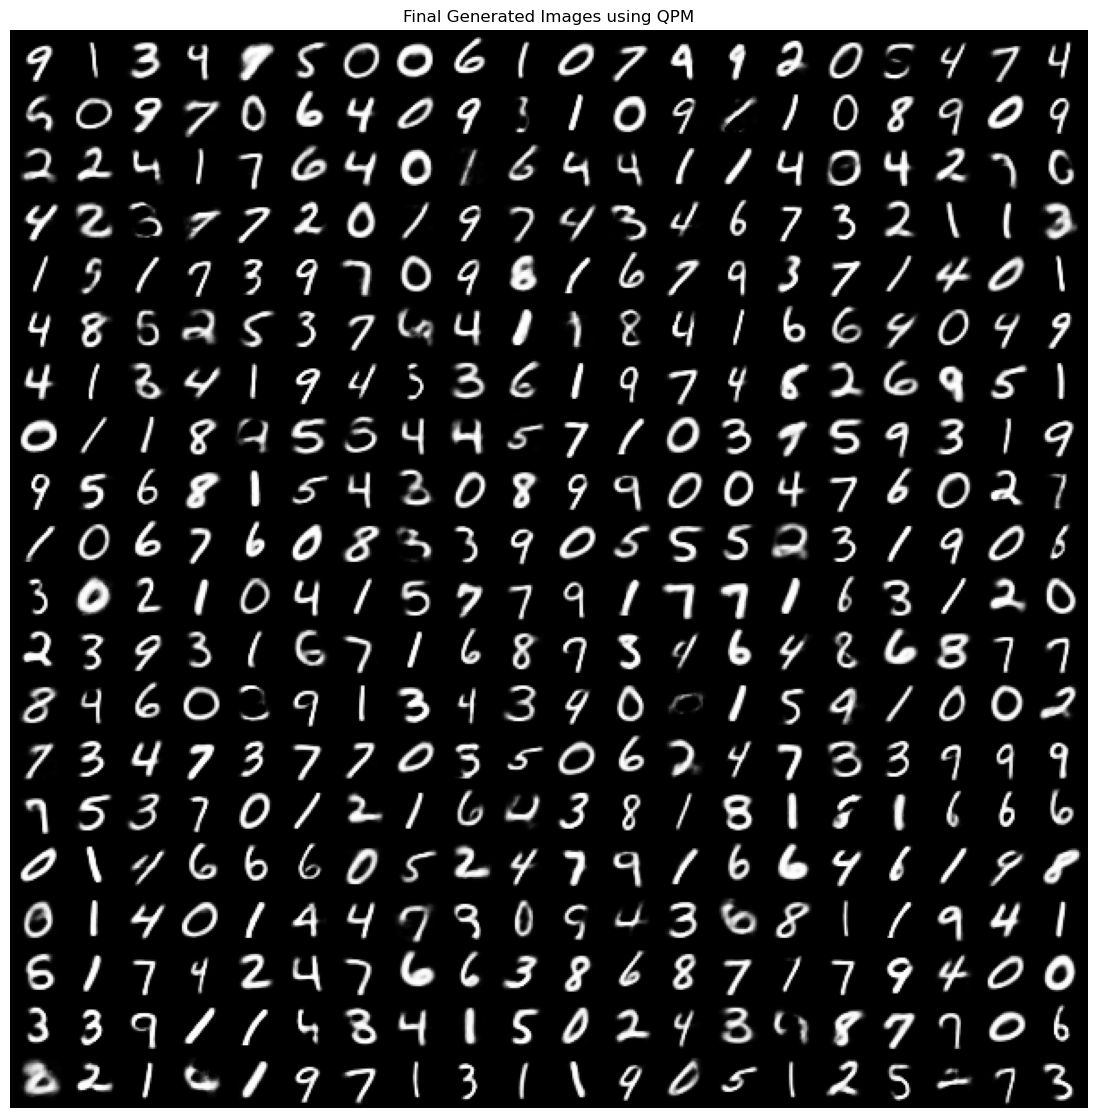

Epochs: 200 	Training Loss: 0.631863 	Total time: 76.9 minutes
Learning rate 0.005
Distance: QPM
Final batch size 1000


In [20]:
# Display and save QPM-generated samples

columns = 20
with torch.no_grad():
    z = noisemaker(columns**2)
    final_gen = model_QPM(z).view(columns**2, image_channels, image_size, image_size).cpu()
show_examples(final_gen, nrow=columns, width=14, title="Final Generated Images using QPM", filestem="MNIST_QPM")

print(f'Epochs: {epoch} \tTraining Loss: {avg_loss_QPM:.6f} \tTotal time: {total_minutes:.1f} minutes')
print("Learning rate", learning_rate)
print("Distance: QPM")
print("Final batch size", batch_size)

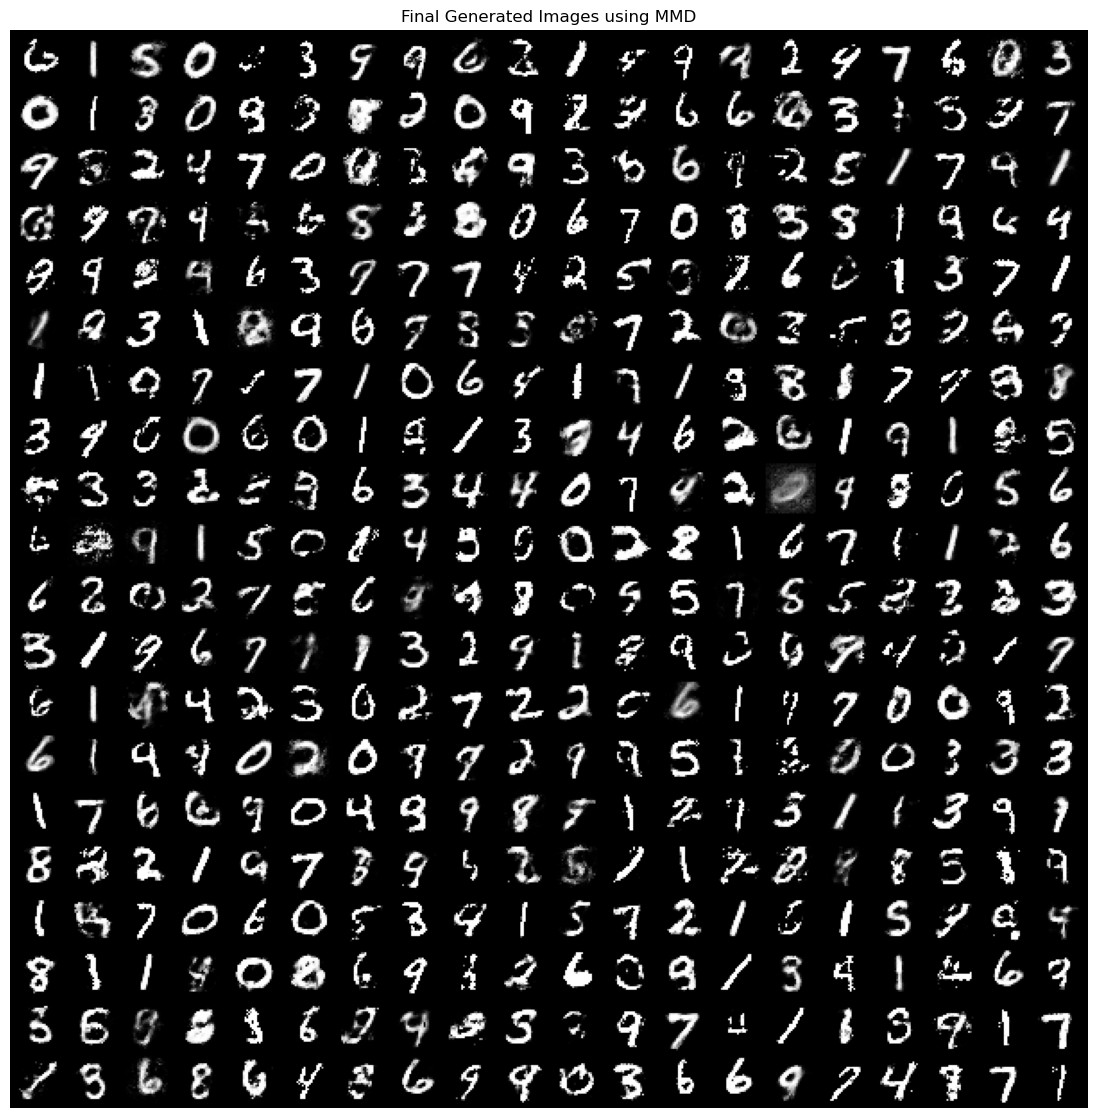

Epochs: 200 	Training Loss: 0.044929 	Total time: 76.9 minutes
Learning rate 0.005
Distance: MMD
Final batch size 1000


In [21]:
# Display and save MMD-generated samples

columns = 20
with torch.no_grad():
    z = noisemaker(columns**2)
    final_gen = model_MMD(z).view(columns**2, image_channels, image_size, image_size).cpu()
show_examples(final_gen, nrow=columns, width=14, title="Final Generated Images using MMD", filestem="MNIST_MMD")

print(f'Epochs: {epoch} \tTraining Loss: {avg_loss_MMD:.6f} \tTotal time: {total_minutes:.1f} minutes')
print("Learning rate", learning_rate)
print("Distance: MMD")
print("Final batch size", batch_size)

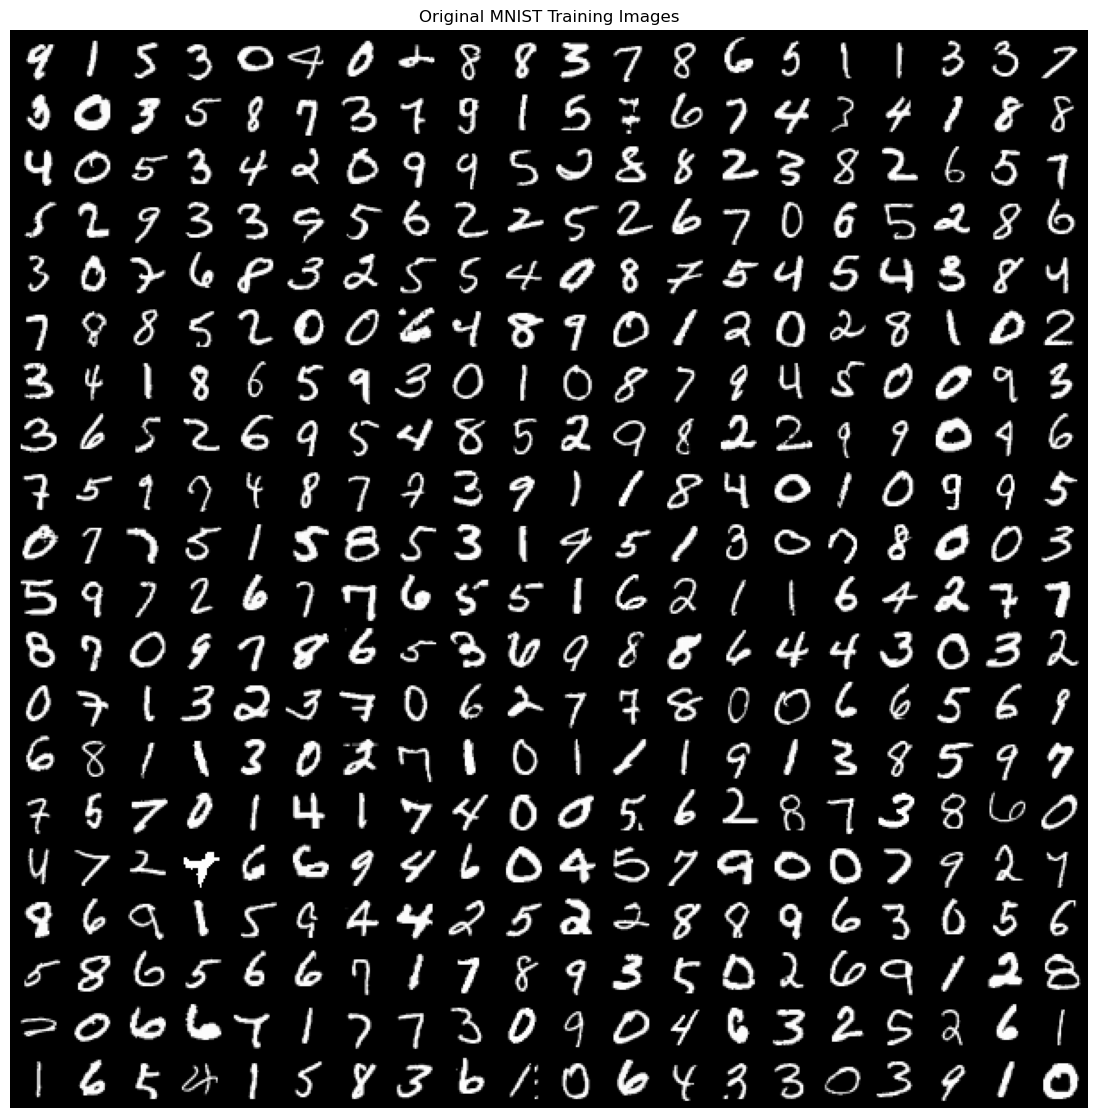

In [22]:
# Display and save original training data, for comparison

total_count = len(x_train)
indices = np.arange(total_count, dtype=int)
rng.shuffle(indices)

columns = 20
select = indices[:columns**2]

train_examples = x_train[select].view(columns**2,1,image_size,image_size)

show_examples(train_examples, nrow=columns, width=14, title="Original MNIST Training Images", filestem="MNIST_data")


In [23]:
# Two-sample testing
# Uses batches from the test/validation set (not used for training)
# Compares each generator with the test data using same metric as used for generation

n_batch = 1000 # batch size for 2-sample testing
n_perm = 1000  # number of permutations

n_tests = 30  # how many independent 2-sample tests should we run?


test_loader = torch.utils.data.DataLoader(x_valid[:], batch_size=n_batch, 
                                          shuffle=True, num_workers=num_workers, pin_memory=pin)

for kind in ['MMD', 'QPM']:
    if kind=='MMD': 
        model = model_MMD
    else:
        model = model_QPM
    
    p_vals = np.zeros(n_tests)
   
    for i in range(n_tests):
    
        orig_batch = next(iter(test_loader))
        batch_size = orig_batch.size(0)
        target = orig_batch.to(device).view(batch_size, -1)
        
        noise = noisemaker(batch_size)
        output = model(noise).view(batch_size, -1)
        gram = compute_Gram(output, target, kind)
        p_vals[i] = perm_test(gram, kind, n_perm)
                
        print(f'Batch: {i+1} \t{kind}: {p_vals[i]:.3f}')

    ave_p = np.average(p_vals)
    
    print('Average:')
    print(f'{kind}: p ~ {ave_p:.3f} over {n_tests} batches')


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 759.21it/s]


Batch: 1 	MMD: 0.005


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 871.84it/s]


Batch: 2 	MMD: 0.001


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 812.21it/s]


Batch: 3 	MMD: 0.001


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 850.59it/s]


Batch: 4 	MMD: 0.008


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 883.88it/s]


Batch: 5 	MMD: 0.001


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 855.76it/s]


Batch: 6 	MMD: 0.009


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 828.62it/s]


Batch: 7 	MMD: 0.005


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 854.09it/s]


Batch: 8 	MMD: 0.011


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 843.72it/s]


Batch: 9 	MMD: 0.003


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 860.08it/s]


Batch: 10 	MMD: 0.001


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 844.70it/s]


Batch: 11 	MMD: 0.001


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 809.80it/s]


Batch: 12 	MMD: 0.002


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 821.18it/s]


Batch: 13 	MMD: 0.002


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 843.28it/s]


Batch: 14 	MMD: 0.004


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 855.85it/s]


Batch: 15 	MMD: 0.003


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 875.24it/s]


Batch: 16 	MMD: 0.001


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 864.97it/s]


Batch: 17 	MMD: 0.001


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 873.01it/s]


Batch: 18 	MMD: 0.027


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 867.83it/s]


Batch: 19 	MMD: 0.036


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 799.02it/s]


Batch: 20 	MMD: 0.001


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 871.41it/s]


Batch: 21 	MMD: 0.003


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 884.14it/s]


Batch: 22 	MMD: 0.020


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 875.63it/s]


Batch: 23 	MMD: 0.004


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 888.32it/s]


Batch: 24 	MMD: 0.003


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 877.03it/s]


Batch: 25 	MMD: 0.005


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 882.85it/s]


Batch: 26 	MMD: 0.003


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 875.35it/s]


Batch: 27 	MMD: 0.007


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 881.70it/s]


Batch: 28 	MMD: 0.003


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 860.09it/s]


Batch: 29 	MMD: 0.001


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 874.60it/s]


Batch: 30 	MMD: 0.001
Average:
MMD: p ~ 0.006 over 30 batches


100%|███████████████████████████████████████| 1000/1000 [04:39<00:00,  3.58it/s]


Batch: 1 	QPM: 0.001


100%|███████████████████████████████████████| 1000/1000 [04:38<00:00,  3.60it/s]


Batch: 2 	QPM: 0.001


100%|███████████████████████████████████████| 1000/1000 [06:37<00:00,  2.52it/s]


Batch: 3 	QPM: 0.001


100%|███████████████████████████████████████| 1000/1000 [58:39<00:00,  3.52s/it]


Batch: 4 	QPM: 0.001


100%|███████████████████████████████████████| 1000/1000 [04:35<00:00,  3.62it/s]


Batch: 5 	QPM: 0.001


100%|███████████████████████████████████████| 1000/1000 [04:36<00:00,  3.62it/s]


Batch: 6 	QPM: 0.001


100%|███████████████████████████████████████| 1000/1000 [04:40<00:00,  3.56it/s]


Batch: 7 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:38<00:00,  3.59it/s]


Batch: 8 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:38<00:00,  3.60it/s]


Batch: 9 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:37<00:00,  3.60it/s]


Batch: 10 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:37<00:00,  3.60it/s]


Batch: 11 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:40<00:00,  3.57it/s]


Batch: 12 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:39<00:00,  3.58it/s]


Batch: 13 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:38<00:00,  3.59it/s]


Batch: 14 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:38<00:00,  3.59it/s]


Batch: 15 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [15:59<00:00,  1.04it/s]


Batch: 16 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:39<00:00,  3.57it/s]


Batch: 17 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:37<00:00,  3.60it/s]


Batch: 18 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:38<00:00,  3.59it/s]


Batch: 19 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:36<00:00,  3.62it/s]


Batch: 20 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:36<00:00,  3.62it/s]


Batch: 21 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:36<00:00,  3.62it/s]


Batch: 22 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:37<00:00,  3.61it/s]


Batch: 23 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:36<00:00,  3.62it/s]


Batch: 24 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:37<00:00,  3.61it/s]


Batch: 25 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:36<00:00,  3.61it/s]


Batch: 26 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:37<00:00,  3.61it/s]


Batch: 27 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:36<00:00,  3.61it/s]


Batch: 28 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [08:34<00:00,  1.94it/s]


Batch: 29 	QPM: 0.001


100%|█████████████████████████████████████████| 1000/1000 [04:34<00:00,  3.64it/s]

Batch: 30 	QPM: 0.001
Average:
QPM: p ~ 0.001 over 30 batches
